In [394]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

import esim_torch

In [395]:
t_refractory_period_ns=1e3;#某个时间段内不会产生event
esim = esim_torch.ESIM(contrast_threshold_neg=0.2, #定义负event的阈值
                        contrast_threshold_pos=0.2, #定义正event的阈值
                        refractory_period_ns=t_refractory_period_ns)  #refractory period in nanoseconds

print("Loading images")
# 读取图片
image_files = sorted(glob.glob("../../esim_py/tests/data/images/images/*.png"))
images = np.stack([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files])
# 读取时间戳
timestamps_s = np.genfromtxt("../../esim_py/tests/data/images/timestamps.txt")
timestamps_ns = (timestamps_s * 1e9).astype("int64")

# 将图片转换为log scale
log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0"
# torch tensor with type float32, shape T x H x W
log_images = torch.from_numpy(log_images).to(device)
# torch tensor with type int64,   shape T (已经转换为tensor)
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
events = esim.forward(log_images, timestamps_ns)

all_event = events
print(f"Total events: {all_event['x'].shape}")


Loading images
Loading data to GPU
Generating events
Total events: torch.Size([156451])


image_size: (180, 240)
画出事件+image
Number of events: 7138


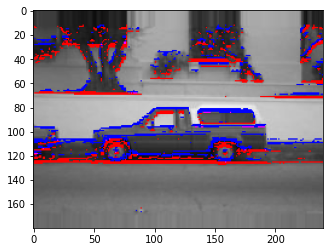

In [396]:
# 选择时间戳范围内的事件
frame_index = 3;
frame_index_range=10;
image0 = images[frame_index] #读取第一张图片
image1 = images[frame_index+frame_index_range] #读取第二张图片
timestamps_ns0=timestamps_ns[frame_index].item() #读取第一张图片的时间戳(注意前面转换成torch了)
timestamps_ns1=timestamps_ns[frame_index+frame_index_range].item() #读取第二张图片的时间戳

event_hw_size = image1.shape
print("image_size:", event_hw_size)

# 将生成的事件画在图像上 
print("画出事件+image")

# 选择时间戳范围内的事件
mask = (all_event['t'] >= timestamps_ns0) & (all_event['t'] < timestamps_ns1)
# 提取事件，并且转换为numpy
event_stream = {k: v[mask].cpu().numpy() for k, v in events.items()}
# 统计事件的数量
num_event=len(event_stream['t'])
print("Number of events:", num_event)
# 将事件的时间从ns转换为s
event_stream['t']=event_stream['t']/1e9

image_color = np.stack([image1,image1,image1],-1)#将三个图像叠加，并沿着最后一个维度堆叠，形成一个彩色图像（RGB）。
image_color[event_stream['y'], event_stream['x'], :] = 0 #将事件的位置设置为黑色
# 由于是BGR，所以-1的时候，对应1-1是蓝色，1的时候，1+1是红色
image_color[event_stream['y'], event_stream['x'], 1+event_stream['p']] = 255

plt.imshow(image_color)
plt.show()

画出Space-time plot;事件数目  7138


/tmp/ipykernel_2369898/1999255340.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)# 创建 3D 坐标系


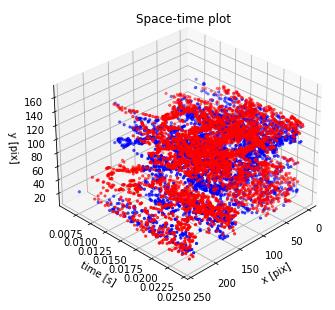

In [397]:
#画出Space-time plot
print("画出Space-time plot;事件数目 ", num_event)
# %% Plot each polarity with a different color (red / blue)
idx_pos = np.asarray(event_stream['p'][:num_event]) > 0 #正事件
idx_neg = np.logical_not(idx_pos) #负事件
xnp = np.asarray(event_stream['x'][:num_event])
ynp = np.asarray(event_stream['y'][:num_event])
tnp = np.asarray(event_stream['t'][:num_event])
# 创建 3D 图形对象
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图
ax=Axes3D(fig)# 创建 3D 坐标系
# 绘制三维散点图
ax.scatter(xnp[idx_pos], tnp[idx_pos], ynp[idx_pos], marker='.', c='b')
ax.scatter(xnp[idx_neg], tnp[idx_neg], ynp[idx_neg], marker='.', c='r')
# 设置坐标轴标签
ax.set(xlabel='x [pix]', ylabel='time [s]', zlabel='y [pix]')
# 视角设置
# ax.view_init(azim=-90, elev=-180) # Change viewpoint with the mouse, for example
ax.view_init(azim=45, elev=30) # 改变视角以便看到三维效果
fig.suptitle('Space-time plot')
# 显示图形
plt.show()

画出Ternary image; 事件数目  7138


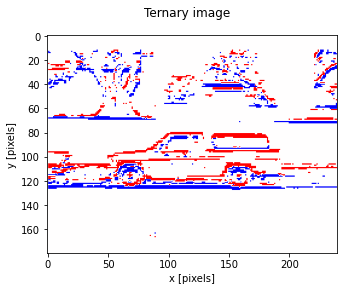

In [398]:
print("画出Ternary image; 事件数目 ", num_event)
# What if we only use 3 values in the event accumulation image?
# Saturated signal: -1, 0, 1
# For example, store the polarity of the last event at each pixel
Ternaryimage = np.zeros(event_hw_size, np.int)
for i in range(num_event):
    Ternaryimage[event_stream['y'][i],event_stream['x'][i]] = (event_stream['p'][i])  # no accumulation; overwrite the stored value

# Display the ternary image
fig = plt.figure()
fig.suptitle('Ternary image')
plt.imshow(Ternaryimage, cmap='bwr')
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
# plt.colorbar()
plt.show()

画出事件累计的image event_frame; 事件数目  7138


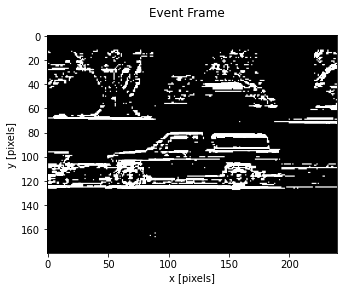

In [399]:
print("画出事件累计的image event_frame; 事件数目 ", num_event)
event_frame = np.zeros(shape=event_hw_size, dtype=int)

for i in range(num_event):
    event_frame[event_stream['y'][i], event_stream['x'][i]] += abs(event_stream['p'][i])

# draw image
fig = plt.figure()
fig.suptitle('Event Frame')
plt.imshow(event_frame, cmap='gray', vmin=0, vmax=1)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
# plt.colorbar()
plt.show()

画出灰度值的累积事件图; 事件数目  7138


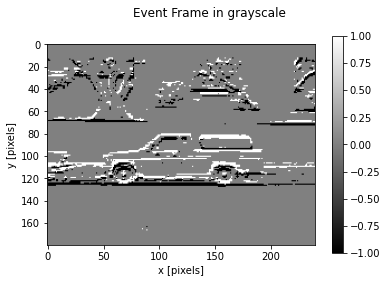

In [400]:
print("画出灰度值的累积事件图; 事件数目 ", num_event)
fig = plt.figure()
fig.suptitle('Event Frame in grayscale')
maxabsval = np.amax(np.abs(Ternaryimage))
plt.imshow(Ternaryimage, cmap='gray', clim=(-maxabsval,maxabsval))
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

画出灰度值的累积事件图（用彩色显示）; 事件数目  7138


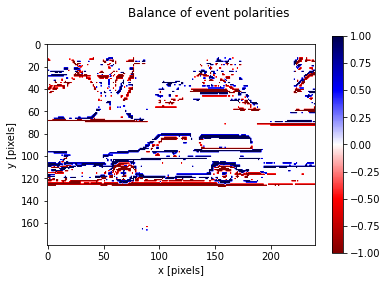

In [401]:
print("画出灰度值的累积事件图（用彩色显示）; 事件数目 ", num_event)
fig = plt.figure()
fig.suptitle('Balance of event polarities')
plt.imshow(Ternaryimage, cmap='seismic_r', clim=(-maxabsval,maxabsval))
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

画出2D Histograms of events; 事件数目  7138


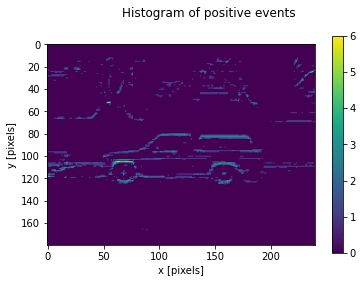

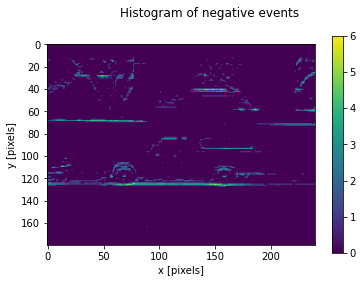

In [402]:
print("画出2D Histograms of events; 事件数目 ", num_event)
# % 2D Histograms of events, split by polarity (positive and negative events in separate images)
img_pos = np.zeros(event_hw_size, np.int)
img_neg = np.zeros(event_hw_size, np.int)
for i in range(num_event):
    if (event_stream['p'][i] > 0):
        img_pos[event_stream['y'][i],event_stream['x'][i]] += 1 # count events
    else:
        img_neg[event_stream['y'][i],event_stream['x'][i]] += 1

fig = plt.figure()
fig.suptitle('Histogram of positive events')
plt.imshow(img_pos)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure()
fig.suptitle('Histogram of negative events')
plt.imshow(img_neg)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

画出Time surface; 事件数目 7138
t_ref= 0.024252666


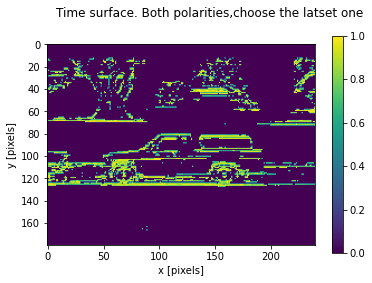

In [403]:
# 画出time surface
print("画出Time surface; 事件数目", num_event)
Timesurface = np.zeros(event_hw_size, np.float64)
t_ref = event_stream['t'][-1] # time of the last event in the packet
print("t_ref=", t_ref)
tau = 0.03 # decay parameter (in seconds)
for i in range(num_event):
    Timesurface[event_stream['y'][i],event_stream['x'][i]] = np.exp(-(t_ref-event_stream['t'][i]) / tau)

fig = plt.figure()
fig.suptitle('Time surface. Both polarities,choose the latset one')
plt.imshow(Timesurface)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

画出带极性的两张time surface


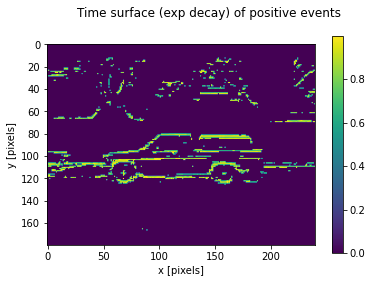

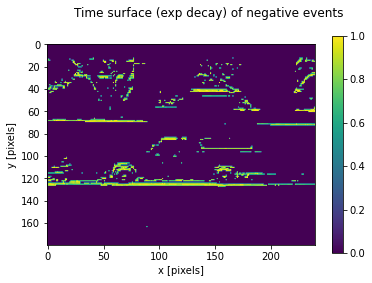

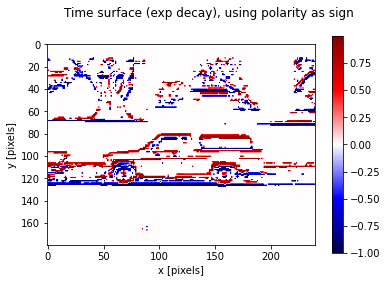

In [404]:
# %% Time surface (or time map, or SAE), separated by polarity
print("画出带极性的两张time surface")
ts_pos = np.zeros(event_hw_size, np.float32)
ts_neg = np.zeros(event_hw_size, np.float32)
ts_pn= np.zeros(event_hw_size, np.float32)
for i in range(num_event):
    ts_pn[event_stream['y'][i],event_stream['x'][i]] =event_stream['p'][i] *np.exp(-(t_ref-event_stream['t'][i]) / tau)
    if (event_stream['p'][i] > 0):
        ts_pos[event_stream['y'][i],event_stream['x'][i]] = np.exp(-(t_ref-event_stream['t'][i]) / tau)
    else:
        ts_neg[event_stream['y'][i],event_stream['x'][i]] = np.exp(-(t_ref-event_stream['t'][i]) / tau)

fig = plt.figure()
fig.suptitle('Time surface (exp decay) of positive events')
plt.imshow(ts_pos)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure()
fig.suptitle('Time surface (exp decay) of negative events')
plt.imshow(ts_neg)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

fig = plt.figure()
fig.suptitle('Time surface (exp decay), using polarity as sign')
plt.imshow(ts_pn, cmap='seismic') # using color (Red/blue)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

Our TS with polarity


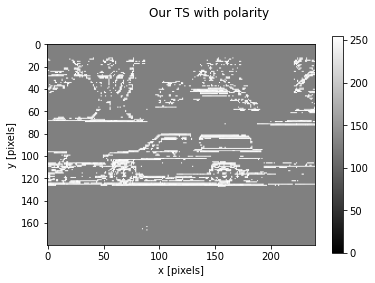

In [405]:
print("Our TS with polarity")
TS_p=np.zeros(event_hw_size, np.float32);
TS_p=255.0*(Timesurface+1.0)/2.0

fig = plt.figure()
fig.suptitle('Our TS with polarity')
plt.imshow(TS_p,cmap='gray', vmin=0, vmax=255.0)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

Our normalize TS without polarity


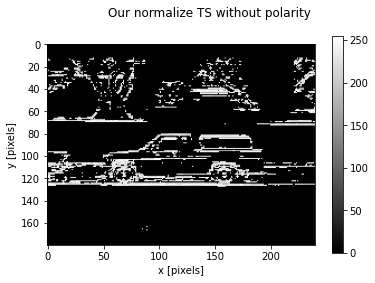

In [406]:
print("Our normalize TS without polarity")
TS_p=np.zeros(event_hw_size, np.float32);
TS_p=255.0*Timesurface+1.0

fig = plt.figure()
fig.suptitle('Our normalize TS without polarity')
plt.imshow(TS_p,cmap='gray', vmin=0, vmax=255.0)
plt.xlabel("x [pixels]")
plt.ylabel("y [pixels]")
plt.colorbar()
plt.show()

画出三维的SAE; Time axis in horizontal position


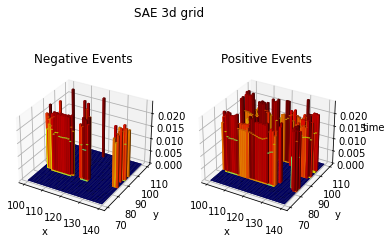

In [407]:
# 画出三维的SAE
print("画出三维的SAE; Time axis in horizontal position")

sae_pos = np.zeros(event_hw_size, np.float64)
sae_neg = np.zeros(event_hw_size, np.float64)
# calculate SAE using expotential decay
for i in range(len(event_stream['t'])):
    if(event_stream['p'][i] == -1):          # only for negative ts.
        sae_neg[event_stream['y'][i], event_stream['x'][i]] = event_stream['t'][i]
    elif(event_stream['p'][i] == 1):          # only for positive ts.
        sae_pos[event_stream['y'][i], event_stream['x'][i]] = event_stream['t'][i]

# select a roi, to avoid to much data.
box_size = 20
roi_x0 = int(event_hw_size[1]/2-box_size);
roi_x1 = int(event_hw_size[1]/2+box_size);
roi_y0 = int(event_hw_size[0]/2-box_size);
roi_y1 = int(event_hw_size[0]/2+box_size);
x_range = np.arange(roi_x0, roi_x1)
y_range = np.arange(roi_y0, roi_y1)

# Create figure and subplots
fig = plt.figure()
# fig.suptitle('SAE 3d grid')

# Negative events subplot
ax_neg = fig.add_subplot(121, projection='3d') #子图
xx, yy = np.meshgrid(x_range, y_range)
x, y = xx.ravel(), yy.ravel()
top_neg = sae_neg[roi_y0:roi_y1, roi_x0:roi_x1].ravel() #将roi区域的数据展平
colors_neg = plt.cm.jet(top_neg / np.max(top_neg)) #将数据归一化到0-1之间（np.max获取最大值，理论上不会出现0或者NaN）
bottom_neg = np.zeros_like(top_neg) #创建一个和top_neg一样大小的全0数组
ax_neg.bar3d(x, y, bottom_neg, 1, 1, top_neg, shade=True, color=colors_neg)
ax_neg.set_xlabel('x')
ax_neg.set_ylabel('y')
ax_neg.set_title('Negative Events')

# Positive events subplot
ax_pos = fig.add_subplot(122, projection='3d')
top_pos = sae_pos[roi_y0:roi_y1, roi_x0:roi_x1].ravel()
colors_pos = plt.cm.jet(top_pos / np.max(top_pos))
bottom_pos = np.zeros_like(top_pos)
ax_pos.bar3d(x, y, bottom_pos, 1, 1, top_pos, shade=True, color=colors_pos)
ax_pos.set_xlabel('x')
ax_pos.set_ylabel('y')
ax_pos.set_zlabel('time')
ax_pos.set_title('Positive Events')

# plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Adjust horizontal space between subplots
plt.suptitle('SAE 3d grid')  # Adjust main title position
plt.show()

画出Voxel grid,只选取前面2000个
num_event= 2000


/tmp/ipykernel_2369898/3366923676.py:55: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


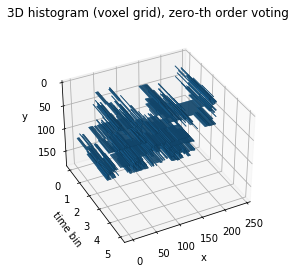

In [408]:
print("画出Voxel grid,只选取前面2000个")
num_bins=5
t_max = np.amax(np.asarray(event_stream['t']))
t_min = np.amin(np.asarray(event_stream['t']))
t_range = t_max - t_min
dt_bin = t_range / num_bins # size of the time bins (bins)
t_edges = np.linspace(t_min,t_max,num_bins+1) # Boundaries of the bins

# event_stream只选取前面2000个
event_stream = {
    't': event_stream['t'][:2000],
    'p': event_stream['p'][:2000],
    'x': event_stream['x'][:2000],
    'y': event_stream['y'][:2000]
}
num_event=len(event_stream['t'])

# Compute 3D histogram of events manually with a loop
# ("Zero-th order or nearest neighbor voting")
hist3d = np.zeros(event_hw_size+(num_bins,), np.int)
for ii in range(num_event):
    idx_t = int( (event_stream['t'][ii]-t_min) / dt_bin )
    if idx_t >= num_bins:
        idx_t = num_bins-1 # only one element (the last one)
    hist3d[event_stream['y'][ii],event_stream['x'][ii],idx_t] += 1

# # Checks:
# print("hist3d")
# print(hist3d.shape)
# print(np.sum(hist3d)) # This should equal the number of votes
print("num_event=",num_event)

# %% Compute 3D histogram of events using numpy function histogramdd
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogramdd.html#numpy.histogramdd

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,event_hw_size[0],event_hw_size[0]+1), 
             np.linspace(0,event_hw_size[1],event_hw_size[1]+1), t_edges)
yxt = np.transpose(np.array([event_stream['y'], event_stream['x'], event_stream['t']]))
hist3dd, edges = np.histogramdd(yxt, bins=bin_edges)

# # Checks
# print("\nhist3dd")
# print("min = ", np.min(hist3dd))
# print("max = ", np.max(hist3dd))
# print(np.sum(hist3dd))
# print(np.linalg.norm( hist3dd - hist3d)) # Check: zero if both histograms are equal
# print("Ratio of occupied bins = ", np.sum(hist3dd > 0) / float(np.prod(hist3dd.shape)) )

# Plot of the 3D histogram. Empty cells are transparent (not displayed)
# Example: https://matplotlib.org/3.1.1/gallery/mplot3d/voxels_rgb.html#sphx-glr-gallery-mplot3d-voxels-rgb-py

fig = plt.figure()
fig.suptitle('3D histogram (voxel grid), zero-th order voting')
ax = fig.gca(projection='3d')
# prepare some coordinates
r, g, b = np.indices((event_hw_size[0]+1,event_hw_size[1]+1,num_bins+1))
ax.voxels(g,b,r, hist3d) # No need to swap the data to plot with reordered axes
ax.set(xlabel='x', ylabel='time bin', zlabel='y')
# ax.view_init(azim=-90, elev=-180) # edge-on, along time axis
ax.view_init(azim=-63, elev=-145) # oblique viewpoint
plt.show()




/tmp/ipykernel_2369898/3909054728.py:31: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


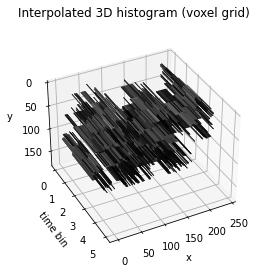

In [409]:
# %% Compute interpolated 3D histogram (voxel grid)
hist3d_interp = np.zeros(event_hw_size+(num_bins,), np.float64)
for ii in range(num_event):
    tn = (event_stream['t'][ii] - t_min) / dt_bin # normalized time, in [0,num_bins]
    ti = np.floor(tn-0.5) # index of the left bin
    dt = (tn-0.5) - ti    # delta fraction
    # Voting on two adjacent bins
    if ti >=0 :
        hist3d_interp[event_stream['y'][ii],event_stream['x'][ii],int(ti)  ] += 1. - dt
    if ti < num_bins-1 :
        hist3d_interp[event_stream['y'][ii],event_stream['x'][ii],int(ti)+1] += dt

# # Checks
# print("\nhist3d_interp")
# print("min = ", np.min(hist3d_interp))
# print("max = ", np.max(hist3d_interp))
# print(np.sum(hist3d_interp))
# # Some votes are lost because of the missing last layer
# print(np.linalg.norm( hist3d - hist3d_interp))
# print("Ratio of occupied bins = ", np.sum(hist3d_interp > 0) / float(np.prod(hist3d_interp.shape)) )

# Plot voxel grid
colors = np.zeros(hist3d_interp.shape + (3,))
tmp = hist3d_interp/np.amax(hist3d_interp) # normalize in [0,1]
colors[..., 0] = tmp
colors[..., 1] = tmp
colors[..., 2] = tmp

fig = plt.figure()
fig.suptitle('Interpolated 3D histogram (voxel grid)')
ax = fig.gca(projection='3d')
ax.voxels(g,b,r, hist3d_interp, facecolors=colors)
ax.set(xlabel='x', ylabel='time bin', zlabel='y')
ax.view_init(azim=-63, elev=-145)
plt.show()

# %% A different visualization viewpoint
ax.view_init(azim=-90, elev=-180) # edge-on, along time axis
plt.show()